<a href="https://colab.research.google.com/github/abbasmammadov/Facial-Expression-Recognition/blob/main/Error_Analysis_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Error analysis

mount your drive first - you can do it just once

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


importing necessary modules

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt

Now we will load our model. In this step, torch needs the original class of the model to be present on the stage where we load it's best parameter (or it's best 'state_dict'). Therefore, first, we have to create the model instance first, and load it's best state dictionary from our drive.

In [ ]:
from collections import OrderedDict
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 7)
data_path = '/content/drive/MyDrive/datasets'
only_fer_path = '/content/drive/MyDrive/ML Project Folder/project/datasets/fer2013'
best_model_path = os.path.join(data_path, 'resnet-50-sgd.h5')
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)

Next, we will convert every image we load in the testset to a normalized tensor.

In [ ]:
#load the dataset, and get the data augmentation ready 
# in this case the data augmentation is only converting it to a normalized tensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
test_augs = T.ToTensor()

# On the whole dataset (FER2013 + CKplus + Affectnet)

In [ ]:
# since we want to evaluate our model in our test dataset, we wll only load our test dataset
test_path = os.path.join(data_path, 'test')

# perform the data augmentation, and store the new dataset
testset = ImageFolder(test_path, transform=test_augs)

print(f"Total no. of examples in testset : {len(testset)}")

##let's load our test dataset in a format suitable to pytorch
testloader = DataLoader(testset)

Total no. of examples in testset : 3589


Now we will evaluate our model on our test data. We will get predictions, and compare them with the true labels.

In [ ]:
#accuracy of the model
from tqdm import tqdm
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
def test_model(model, dataloader, current_epoch=1):
  # initialize the test tensors
  true_labels = torch.zeros((len(dataloader)))
  predictions = torch.zeros((len(dataloader)))
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  # tk = tqdm(dataloader, desc='EPOCH' + '[TEST]' + str(current_epoch) + "/" + str(1))
  print('Evaluating accuracy on the test set........')
  for t, data in enumerate(dataloader):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    logits = model(images)
    loss = nn.CrossEntropyLoss()(logits,  labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    predictions[t], true_labels[t] = logits.argmax(1), labels
    # tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return {'loss': total_loss/len(dataloader), 'accuracy': total_acc / len(dataloader), 'predictions': predictions, 'true_labels': true_labels}

In [ ]:
test_info = test_model(model, testloader)
test_loss, test_acc, predictions, true_labels = test_info['loss'], test_info['accuracy'], test_info['predictions'], test_info['true_labels']
print('accuracy:', float(test_acc))

Evaluating accuracy on the test set........
accuracy: 0.6104764342308044


Now we will analyze how correctly each emotions are being classified by our model using confusion matrix from the scikit-learn library

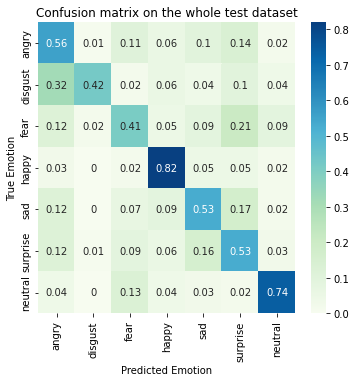

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

#the label encoding used in our CSV file -> encoding which maps to emotion 
em_dict = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
num_classes = 7

#build a heatmap which helps us to visualize the confusion matrix
conf_mat_colored = pd.DataFrame(confusion_matrix(true_labels, predictions, normalize='true').round(2), index=em_dict.values(), columns=em_dict.values())

#now plot it
plt.figure(figsize=(5,5))
heatmap(conf_mat_colored, annot=True, cmap=plt.cm.GnBu)
plt.tight_layout()
plt.title('Confusion matrix on the whole test dataset')
plt.ylabel('True Emotion')
plt.xlabel('Predicted Emotion')
plt.show()


To demonstrate how the proportion of each labels contribute to the accuracy of our model, let's make some data analysis on the entire dataset and try to count the proportion of each emotion

In [ ]:
csv_path = os.path.join(data_path, 'fer2013.csv')
data_df = pd.read_csv(csv_path)
labels = data_df['emotion']

In [ ]:
from collections import Counter
# now we can count the proportion of each emotion
labled_num_emotions = Counter(labels) # this counter labels each emotions as numbers. Therefore, let's use our 'em_dict' to convert them into the emotions
num_fer_emotions = {em_dict[label]: nums for (label, nums) in labled_num_emotions.items()}
print(num_fer_emotions)

{'angry': 4953, 'fear': 5121, 'sad': 6077, 'neutral': 6198, 'happy': 8989, 'surprise': 4002, 'disgust': 547}


In [ ]:
# we can also print proportions of each emotions
prop_fer_emotions = {emotion: round(nums/len(data_df), 4) for (emotion, nums) in num_fer_emotions.items()}
print(prop_fer_emotions)

{'angry': 0.138, 'fear': 0.1427, 'sad': 0.1693, 'neutral': 0.1727, 'happy': 0.2505, 'surprise': 0.1115, 'disgust': 0.0152}


In [ ]:
# now let's examine the impact of adding the auxiliary datasets
aff_label_path = os.path.join(data_path, 'labels.csv')
data_df2 = pd.read_csv(aff_label_path)
num_aff_emotions = {emotion: num for emotion,num in Counter(data_df2['label']).items() if emotion != 'contempt'}
print(num_aff_emotions)

{'surprise': 4889, 'anger': 4160, 'fear': 3753, 'disgust': 3776, 'sad': 3352, 'neutral': 3102, 'happy': 4382}


In [ ]:
#now let's add up those dictionaries, and compare the confusion matrix
fer_aff_emotions = {emotion: num1+num2 for emotion, num1 in num_fer_emotions.items() for emotion2, num2 in num_aff_emotions.items() if emotion[:3]==emotion2[:3]}
print(fer_aff_emotions)

{'angry': 9113, 'fear': 8874, 'sad': 9429, 'neutral': 9300, 'happy': 13371, 'surprise': 8891, 'disgust': 4323}


In [ ]:
num_ckp_emotions = {'anger': 135, 'disgust': 177, 'fear': 75, 'happy': 207, 'sadness': 84, 'surprise': 249}
total_emotions = {emotion: num1+num2 for emotion, num1 in fer_aff_emotions.items() for emotion2, num2 in num_ckp_emotions.items() if emotion[:3]==emotion2[:3]}
print(total_emotions)

{'angry': 9248, 'fear': 8949, 'sad': 9513, 'happy': 13578, 'surprise': 9140, 'disgust': 4500}


In [ ]:
prop_emotions = {emotion: round(nums/len(data_df), 4) for (emotion, nums) in total_emotions.items()}
print(prop_emotions)

{'angry': 0.2577, 'fear': 0.2494, 'sad': 0.2651, 'happy': 0.3784, 'surprise': 0.2547, 'disgust': 0.1254}


Now we can see that by adding auxiliary datasets we have atleast increased the proportion of the "disgust" images from 1% to 12.5% which highly sounds an improvement to the balance in the distribution of the labels of the dataset.

Next we'll compare this confusion matrix with the one which is obtained by training our model only on FER2013 dataset

# Only on FER2013

Let's perform the same analysis only on FER2013 dataset and let's compare the confusion matrix we get

In [ ]:

test_path = os.path.join(only_fer_path, 'test')

# perform the data augmentation, and store the new dataset
testset = ImageFolder(test_path, transform=test_augs)

print(f"Total no. of examples in testset : {len(testset)}")

##let's load our test dataset in a format suitable to pytorch
testloader = DataLoader(testset)

Total no. of examples in testset : 3589


Now let's load the model we have trained only on FER2013 dataset

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(OrderedDict([
    ('dropout1', nn.Dropout(p=0.5)), 
    ('fc1', nn.Linear(model.fc.in_features, 4096)), 
    ('relu1', nn.ReLU(inplace=True)), 
    ('dropout2', nn.Dropout(p=0.5)), 
    ('fc2', nn.Linear(4096, 1024)), 
    ('relu2', nn.ReLU(inplace=True)), 
    ('dropout3', nn.Dropout(p=0.5)), 
    ('fc4', nn.Linear(1024, 7)), 
]))
model_path = '/content/drive/MyDrive/ML Project Folder/Models'
best_model_path = os.path.join(model_path, 'best-resnet.h5')
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)

In [ ]:
test_info = test_model(model, testloader)
test_loss, test_acc, predictions, true_labels = test_info['loss'], test_info['accuracy'], test_info['predictions'], test_info['true_labels']
print('accuracy:', float(test_acc))

Evaluating accuracy on the test set........
accuracy: 0.6210643649101257


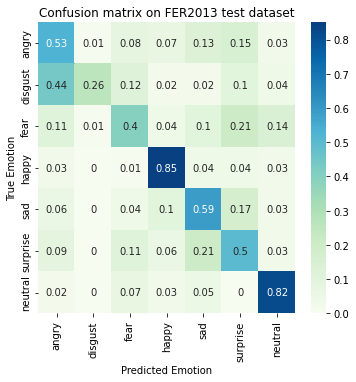

In [ ]:
#Now build a heatmap which helps us to visualize the confusion matrix
conf_mat_colored = pd.DataFrame(confusion_matrix(true_labels, predictions, normalize='true').round(2), index=em_dict.values(), columns=em_dict.values())

#now plot it
plt.figure(figsize=(5,5))
heatmap(conf_mat_colored, annot=True, cmap=plt.cm.GnBu)
plt.tight_layout()
plt.title('Confusion matrix on FER2013 test dataset')
plt.ylabel('True Emotion')
plt.xlabel('Predicted Emotion')
plt.show()

# Comparision of the 2 confusion matrices

In the second confusion matrix, we can see that most of the images have been correctly classified to their categories, but if we see the 'disgust' column, we can see that it's the category in which fewer acutal 'disgust' images are correctly classified as 'disgust', and for our surprise, there is almost no any emotion which has been misclassified as 'disgust'. As we have discussed earlier, this is due to the presence of small amount of images labled as 'disgust'.


We can also understand from our proportion dictionaries that 'disgust' has very small contribution on our whole dataset. Therefore, it's contribution will be much diminished when we divide the data into train, validation and test sets. Therefore, the model wouldn't learn much about this emotion. That's why we have smaller accuracy there.

### What happened after we have added auxiliary datasets? 

The proportion dictionaries showed an increase in the contribution of 'disgust' and other 'minor' images to the dataset. Then, after training our model with the augmented dataset, we were able to achieve the confusion matrix (Figure - 1). We can see that the percentage of 'disgust' images which have been correctly classified has increased from 26% to 42%. 